Procesamiento de datos con SQLite3
===

* Este tutorial esta basado en https://es.hortonworks.com/tutorial/how-to-process-data-with-apache-hive/

* El objetivo de este tutorial es implemetar consultas en SQLite3 para analizar, procesar y filtrar datos usando lenguaje SQL estándar.

Fuentes de datos
---

Los archivos usados en este tutorial se encuentran almacenados en la carpeta actual

In [1]:
import pandas as pd
import glob

filenames = [
    "drivers.csv",
    "timesheet.csv",
    "truck_event_text_partition.csv",
]

url = "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/drivers/"

for filename in filenames:
    pd.read_csv(url+filename).to_csv("/tmp/" + filename, index=False)
    
glob.glob("/tmp/*.csv")

['/tmp/timesheet.csv',
 '/tmp/drivers.csv',
 '/tmp/data.csv',
 '/tmp/truck_event_text_partition.csv']

Preparación
---

In [2]:
#
# Apertura de la conexión
#
import sqlite3

conn = sqlite3.connect(":memory:")  ## aca se indica el nombre de la db.
cur = conn.cursor()

El contenido de un archivo puede ser visualizado parcialmente usando el comando `tail`. Se usa para realizar una inspección rápida del contenido de los archivos.

In [3]:
#
# Se imprime el final del archivo drivers
#
!tail -n 5 /tmp/drivers.csv

39,David Kaiser,967706052,9185 At Street,Y,hours
40,Nicolas Maillard,208510217,1027 Quis Rd.,Y,hours
41,Greg Phillips,308103116,P.O. Box 847- 5961 Arcu. Road,Y,hours
42,Randy Gelhausen,853302254,145-4200 In- Avenue,Y,hours
43,Dave Patton,977706052,3028 A- St.,Y,hours


In [4]:
!tail -n 5 /tmp/timesheet.csv

43,48,52,2517
43,49,56,2743
43,50,59,2665
43,51,58,2593
43,52,48,2764


Creación y carga de datos de datos para la tabla `drivers` usando pandas
---

En el siguiente código, los datos son cargados con pandas, para luego crear la tabla de la base de datos a partir del DataFrame. Note que no hay que crear la tabla primero en la base de datos, sino que pandas la crea directamente.

In [5]:
import pandas as pd

drivers = pd.read_csv(
    "/tmp/drivers.csv",
    sep=",",
    thousands=None,
    decimal=".",
    encoding="latin-1",
)

drivers.columns = [col.replace('-', '_') for col in drivers.columns]

drivers.to_sql(
    name="drivers",
    con=conn,
    if_exists="replace",  # {‘fail’, ‘replace’, ‘append’}
)

34

Se obtiene el primer registro de la tabla para realizar una inspección rápida de los datos y verificar que los datos fueron cargados correctamente.

In [6]:
drivers[0:1]

,driverId,name,ssn,location,certified,wage_plan
0,10,George Vetticaden,621011971,244-4532 Nulla Rd.,N,miles


In [7]:
cur.execute("SELECT * FROM drivers LIMIT 1;").fetchall()

[(0, 10, 'George Vetticaden', 621011971, '244-4532 Nulla Rd.', 'N', 'miles')]

Creación y carga de datos de la tabla `timesheet`
---

Se procede a cargar los datos para el archivo `time_sheet`.

In [8]:
timesheet = pd.read_csv(
    "/tmp/timesheet.csv", sep=",", thousands=None, decimal=".", encoding="latin-1"
)

timesheet.columns = [col.replace('-', '_') for col in timesheet.columns]

timesheet.to_sql(name="timesheet", con=conn, if_exists="replace")

1768

In [9]:
timesheet[0:1]

,driverId,week,hours_logged,miles_logged
0,10,1,70,3300


In [10]:
cur.execute(
    "SELECT driverId, week, hours_logged, miles_logged  FROM timesheet LIMIT 1;"
).fetchall()

[(10, 1, 70, 3300)]

Cantidad de horas y millas de cada conductor por año.
----

En la siguiente consulta se desea obtener para cada conductor la cantidad de horas y millas por año.

In [11]:
cur.execute(
    """
SELECT 
    driverId, 
    sum(hours_logged), 
    sum(miles_logged) 
FROM 
    timesheet 
GROUP BY 
    driverId;
"""
).fetchall()

[(10, 3232, 147150),
 (11, 3642, 179300),
 (12, 2639, 135962),
 (13, 2727, 134126),
 (14, 2781, 136624),
 (15, 2734, 138750),
 (16, 2746, 137205),
 (17, 2701, 135992),
 (18, 2654, 137834),
 (19, 2738, 137968),
 (20, 2644, 134564),
 (21, 2751, 138719),
 (22, 2733, 137550),
 (23, 2750, 137980),
 (24, 2647, 134461),
 (25, 2723, 139180),
 (26, 2730, 137530),
 (27, 2771, 137922),
 (28, 2723, 137469),
 (29, 2760, 138255),
 (30, 2773, 137473),
 (31, 2704, 137057),
 (32, 2736, 137422),
 (33, 2759, 139285),
 (34, 2811, 137728),
 (35, 2728, 138727),
 (36, 2795, 138025),
 (37, 2694, 137223),
 (38, 2760, 137464),
 (39, 2745, 138788),
 (40, 2700, 136931),
 (41, 2723, 138407),
 (42, 2697, 136673),
 (43, 2750, 136993)]

Subconsultas
---

In [12]:
#
# Selecciona todos los registros de la tabla timesheet
# que tienen el driverId igual al menor driverId de la
# tabla drivers.
#
cur.execute(
    """
SELECT 
    *
FROM
    timesheet
WHERE
    driverId = (SELECT min(driverId) FROM drivers);
"""
).fetchall()

[(0, 10, 1, 70, 3300),
 (1, 10, 2, 70, 3300),
 (2, 10, 3, 60, 2800),
 (3, 10, 4, 70, 3100),
 (4, 10, 5, 70, 3200),
 (5, 10, 6, 70, 3300),
 (6, 10, 7, 70, 3000),
 (7, 10, 8, 70, 3300),
 (8, 10, 9, 70, 3200),
 (9, 10, 10, 50, 2500),
 (10, 10, 11, 70, 2900),
 (11, 10, 12, 70, 3100),
 (12, 10, 13, 70, 3300),
 (13, 10, 14, 70, 3300),
 (14, 10, 15, 70, 3300),
 (15, 10, 16, 70, 3400),
 (16, 10, 17, 70, 3300),
 (17, 10, 18, 70, 3300),
 (18, 10, 19, 70, 3300),
 (19, 10, 20, 30, 1200),
 (20, 10, 21, 50, 2500),
 (21, 10, 22, 70, 3300),
 (22, 10, 23, 70, 3300),
 (23, 10, 24, 70, 3300),
 (24, 10, 25, 70, 3300),
 (25, 10, 26, 60, 2600),
 (26, 10, 27, 66, 2700),
 (27, 10, 28, 33, 1200),
 (28, 10, 29, 70, 3300),
 (29, 10, 30, 70, 3300),
 (30, 10, 31, 72, 3100),
 (31, 10, 32, 70, 3200),
 (32, 10, 33, 70, 3300),
 (33, 10, 34, 70, 3300),
 (34, 10, 35, 0, 0),
 (35, 10, 36, 19, 1000),
 (36, 10, 37, 65, 2700),
 (37, 10, 38, 70, 3300),
 (38, 10, 39, 70, 3300),
 (39, 10, 40, 70, 3100),
 (40, 10, 41, 70, 3300)

Consulta para unir las tablas
---

El paso final consiste en crear una consulta que agregue el nombre del conductor de la tabla `drivers` con la cantidad de horas y millas por año.

In [13]:
cur.execute(
    """
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged)total_hours, 
        sum(miles_logged)total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId);
"""
).fetchall()

[(10, 'George Vetticaden', 3232, 147150),
 (11, 'Jamie Engesser', 3642, 179300),
 (12, 'Paul Coddin', 2639, 135962),
 (13, 'Joe Niemiec', 2727, 134126),
 (14, 'Adis Cesir', 2781, 136624),
 (15, 'Rohit Bakshi', 2734, 138750),
 (16, 'Tom McCuch', 2746, 137205),
 (17, 'Eric Mizell', 2701, 135992),
 (18, 'Grant Liu', 2654, 137834),
 (19, 'Ajay Singh', 2738, 137968),
 (20, 'Chris Harris', 2644, 134564),
 (21, 'Jeff Markham', 2751, 138719),
 (22, 'Nadeem Asghar', 2733, 137550),
 (23, 'Adam Diaz', 2750, 137980),
 (24, 'Don Hilborn', 2647, 134461),
 (25, 'Jean-Philippe Playe', 2723, 139180),
 (26, 'Michael Aube', 2730, 137530),
 (27, 'Mark Lochbihler', 2771, 137922),
 (28, 'Olivier Renault', 2723, 137469),
 (29, 'Teddy Choi', 2760, 138255),
 (30, 'Dan Rice', 2773, 137473),
 (31, 'Rommel Garcia', 2704, 137057),
 (32, 'Ryan Templeton', 2736, 137422),
 (33, 'Sridhara Sabbella', 2759, 139285),
 (34, 'Frank Romano', 2811, 137728),
 (35, 'Emil Siemes', 2728, 138727),
 (36, 'Andrew Grande', 2795, 138

In [14]:
#
# Conductor con más horas registradas
#
cur.execute(
    """
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged)total_hours, 
        sum(miles_logged)total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId)
ORDER BY
    t.total_hours DESC
LIMIT 1;
"""
).fetchall()

[(11, 'Jamie Engesser', 3642, 179300)]

Creación de un DataFrame usando una consulta
---

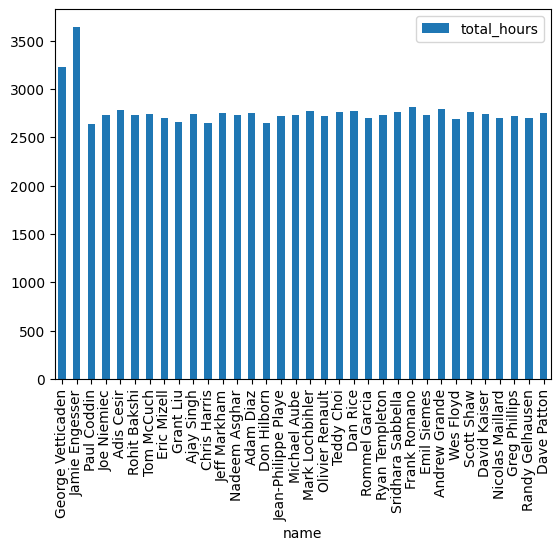

In [15]:
df = pd.read_sql(
    """
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged) total_hours, 
        sum(miles_logged) total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId);
""",
    con=conn,
)

import matplotlib as mpl
import matplotlib.pyplot as plt

df.plot.bar(x="name", y="total_hours");

Almacenamiento de los resultados
---

Los resultados de la consulta son cargados directamente a variable `summary` c como una lista de tuplas. El contenido de la variable es transformado para escribir un archivo de texto en formato CSV que pueda ser consultado por otras aplicaciones.

In [16]:
summary = cur.execute(
    """
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged) total_hours, 
        sum(miles_logged) total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId)
ORDER BY
    d.name;
"""
).fetchall()

text = [[str(e) for e in row] for row in summary]
text = [",".join(row) for row in text]
text = "\n".join(text)
open("/tmp/summary.csv", "wt").write(text)

960

In [17]:
!head /tmp/summary.csv

23,Adam Diaz,2750,137980
14,Adis Cesir,2781,136624
19,Ajay Singh,2738,137968
36,Andrew Grande,2795,138025
20,Chris Harris,2644,134564
30,Dan Rice,2773,137473
43,Dave Patton,2750,136993
39,David Kaiser,2745,138788
24,Don Hilborn,2647,134461
35,Emil Siemes,2728,138727
